In [1]:
from qiskit.providers.fake_provider import FakeGuadalupe,FakeToronto,FakeWashington,FakeCairo

from aais.ibm import get_mach
from simuq.solver import generate_as
from systems.qaoa import qs
from qiskit import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub="ibm-q-ornl", group="ornl", project="phy147")
backend=FakeCairo()
# backend=provider.get_backend("ibmq_guadalupe")
mach=get_mach(backend)

ValueError: This machine is not supported!

In [2]:
assembly=generate_as(qs, mach, 1)
with open("qaoa.as","w+") as f:
    f.write(str(assembly[1])+"\n")
    for item in assembly[2]:
        f.write(str(item)+"\n")
    for item in assembly[3]:
        f.write(str(item)+"\n")

In [3]:
from backends.Analog_Hamiltonian_Simulation.Analog_Hamiltonian_Simulator.IBM_Machine_new import (
    IBM_Machine,
)
from backends.Analog_Hamiltonian_Simulation.Analog_Hamiltonian_Simulator.Program import Program

machine = IBM_Machine(backend)
program = Program(machine)
program.init_from_file("qaoa.as")

#Schedule the instructions greedily using the sorted DAG
program.schedule()

# program.concrete_schedule.draw()
# program.concrete_schedule.simulate()

# generate the pulse schedule
program.transpile()
# program.pulse_schedule.draw()

program.pulse_schedule.generate_external_schedule()
# program.pulse_schedule.draw_external_schedule()


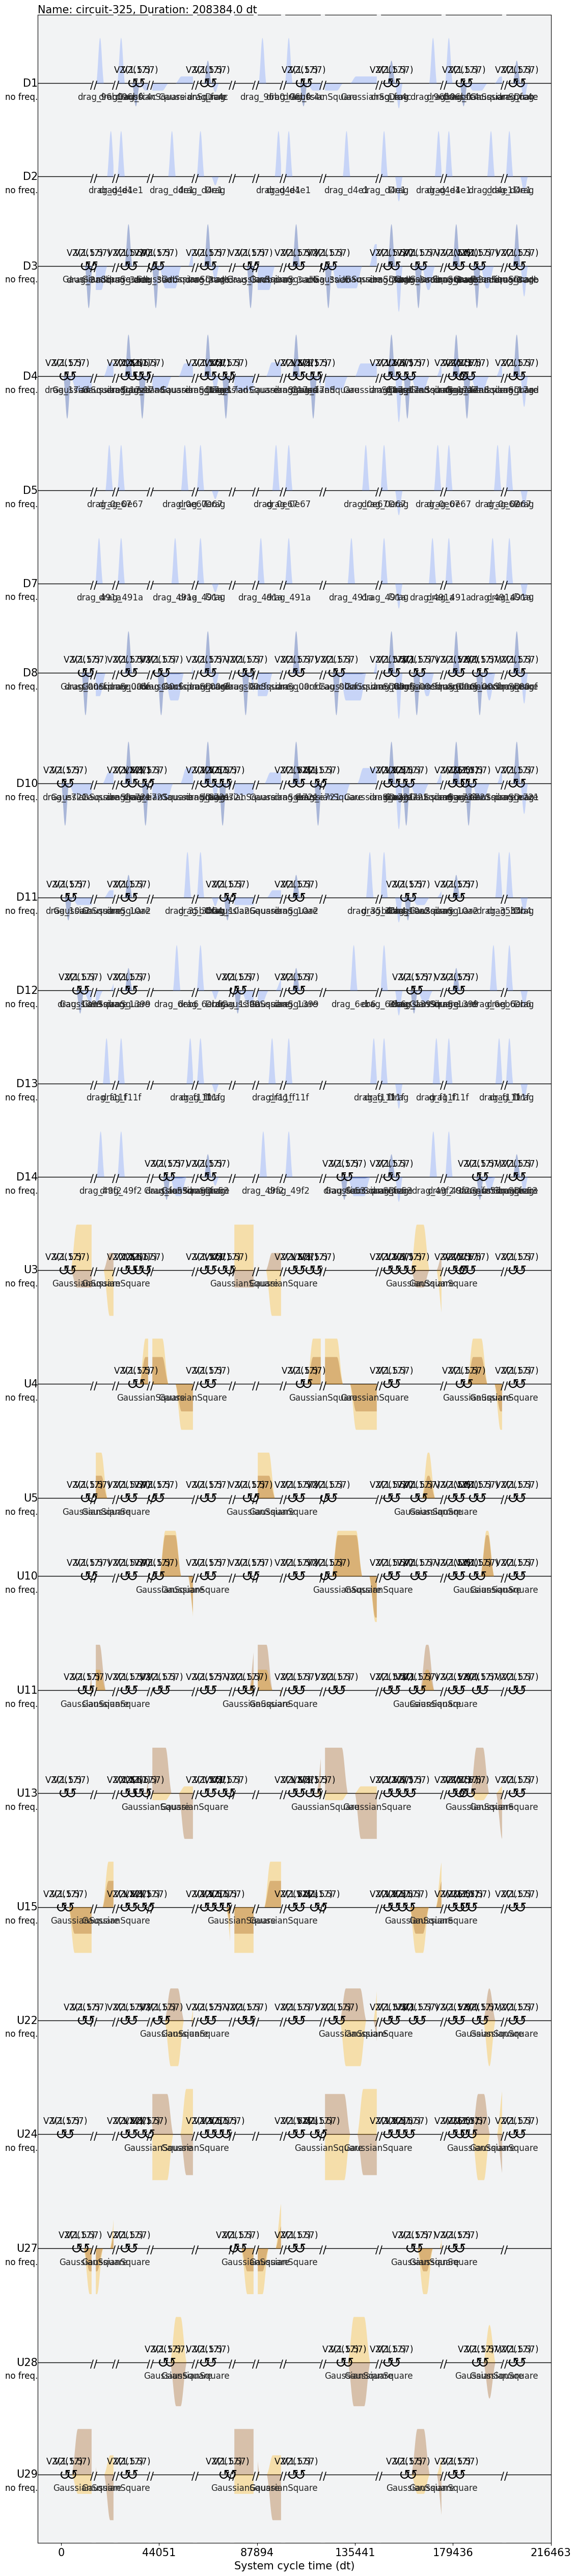

In [8]:
import numpy as np
from qiskit import QuantumCircuit, schedule, transpile
from qiskit.quantum_info import Operator

from backends.Analog_Hamiltonian_Simulation.qiskit_transpiler import get_pm

pm=get_pm(backend)
qc=QuantumCircuit(16)
links=[1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
parameter_list = (
    np.array(
        [
            0.5702193 * 2,
            -0.58631086,
            0.85160685 * 2,
            -1.7058538,
            0.29468536 * 2,
            -1.132814,
        ]
    )
)
for j in range(3):
    for i in range(6):
        qc.rzz(parameter_list[2*j],links[2*i+1],links[(2*i+2)%12])
    qc.barrier()
    for i in range(6):
        qc.rzz(parameter_list[2*j],links[2*i],links[(2*i+1)%12])
    qc.barrier()
    for i in range(12):
        qc.rx(parameter_list[2*j+1],links[i])
    qc.barrier()

qc=pm.run(qc)
qc=transpile(qc,backend)
sched=schedule(qc,backend)
sched.draw()

In [ ]:
# This cell runs the qiskit pulse schedule on the real device
job=backend.run(sched)
from my_monitor import my_job_monitor
my_job_monitor(job)
result=job.result()
counts=result.get_counts()
print(counts)

In [5]:
pulse_schedule=program.pulse_schedule.external_schedule 
qc=QuantumCircuit(16)
for i in links:
    qc.h(i)
h_sched=schedule(transpile(qc,backend),backend)

qc=QuantumCircuit(16)
for i in links:
    # This rz is only used as a barrier
    qc.z(i)
qc.measure_all()
meas_schedule=schedule(transpile(qc,backend),backend)
all_schedule=h_sched+pulse_schedule+meas_schedule


In [7]:
# This cell runs the simuq pulse schedule on the real device
job=backend.run(pulse_schedule)
from my_monitor import my_job_monitor
my_job_monitor(job)
result=job.result()
counts=result.get_counts()
print(counts)

Job Status: job is queued (3)     	 est. wait 0.717 min	 priority: 1(hub), 1(group), 1(proj)	 job id: 634df94c6c7c4806016bf1dbb